In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

import gc

from sklearn import metrics

import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

In [2]:
attrition=pd.read_csv('Attrition_model.csv')
attrition = attrition[attrition['intended_usage']=='P']
attrition = attrition[attrition['term_active']=='active']

In [35]:
attrition[attrition['weeks_to_cancel']==1]

,usernum,enrollment_date,cancellation_date,cancel_end_reason,participant_typenum,cancellation_type,weeks_to_cancel,term_active,typenum_1day_before_enrollment,provider_channel,...,medianage,medianagemale,medianagefemale,population,numberofbusinesses,locationid,distance,attrition_flag,moving_avg_30_days_at_enrollment,moving_avg_prct_change_at_enrollment
72,40848149,5/5/2023,5/8/2023,client_initiated_unhappy_with_allocs,4,Voluntary,1.0,active,1,FE Direct,...,40.2,39.9,40.5,12835.0,96.0,184.0,44.0,1,4124,0.0371
281,52259049,12/14/2021,12/22/2021,client_initiated_unclear_on_benefit,4,Voluntary,1.0,active,1,FE Direct,...,37.3,36.0,38.4,45144.0,774.0,153.0,11.0,1,4648,-0.0350
961,22401955,5/5/2022,5/10/2022,client_initiated_unhappy_with_allocs,4,Voluntary,1.0,active,4,FE Direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4330,-0.2903
1223,27850694,9/12/2023,9/22/2023,client_initiated_unhappy_with_allocs,4,Voluntary,1.0,active,1,FE Direct,...,38.0,37.2,38.8,42731.0,843.0,95.0,5.0,1,4446,-0.0016
1935,51978032,4/26/2023,5/1/2023,client_initiated_no_reason_given,4,Voluntary,1.0,active,1,Advisor Partner,...,36.3,35.9,36.7,22800.0,651.0,24.0,20.0,1,4106,0.0637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351983,57011960,10/21/2023,10/24/2023,client_initiated_prefer_mng_themselves,4,Voluntary,1.0,active,1,Advisor Partner,...,36.7,36.6,36.8,20254.0,564.0,52.0,10.0,1,4306,-0.0819
352168,56169588,12/30/2021,1/4/2022,client_initiated_prefer_mng_themselves,4,Voluntary,1.0,active,1,Advisor Partner,...,39.1,37.2,41.5,22138.0,1304.0,141.0,12.0,1,4667,0.1515
352456,52338878,9/14/2022,9/19/2022,client_initiated_free_promo_expired,4,Voluntary,1.0,active,1,Advisor Partner,...,36.2,36.8,35.4,26599.0,2499.0,128.0,18.0,1,4068,-0.2869
352627,19920390,10/20/2022,10/24/2022,client_initiated_enroll_onl_by_mistake,4,Voluntary,1.0,active,3,FE Direct,...,45.1,42.7,46.8,56490.0,1035.0,12.0,5.0,1,3664,-0.1727


In [37]:
vol = attrition[(attrition['cancellation_type'] != 'Involuntary') & (attrition['weeks_to_cancel'] != 1)]
vol['attrit_flag'] = vol['weeks_to_cancel'].apply(lambda x: 1 if 2 <= x <= 24 else 0)
vol = vol.drop('attrition_flag',1)
vol.rename(columns={'attrit_flag': 'attrition_flag'}, inplace=True)

In [6]:
random_sample = vol.sample(n=100, random_state=42)
random_sample.to_csv('Attrition_subset100.csv')

# Attrition Rate: 4.01%

In [38]:
attrition_rate = (sum(vol['attrition_flag'])/len(vol['attrition_flag'].index))*100
attrition_rate

4.012194416037972

In [39]:
data = vol.drop(columns = ['cancellation_date', 'cancel_end_reason', 'cancellation_type',
                                   'weeks_to_cancel', 'rk_name','sponsor_name'
                                 ,'industry_name','participant_typenum','intended_usage','plan_owner_id','term_active'
                          ,'provider_channel','company_stock_q0','company_stock_q2','company_stock_q3','company_stock_q1'
                          ,'typenum_1day_before_enrollment','medianage','medianagefemale','medianagemale','population',
                          'zip','locationid','moving_avg_30_days_at_enrollment','moving_avg_prct_change_at_enrollment'])
data

,usernum,enrollment_date,rk_id,industrynum,asset_q0,income_q0,asset_q1,income_q1,asset_q2,income_q2,...,web_visits_w4,wpi_clicks_w1,wpi_clicks_w2,wpi_clicks_w3,wpi_clicks_w4,averagehousevalue,incomeperhousehold,numberofbusinesses,distance,attrition_flag
0,34126385,10/30/2021,fmr,21.0,30445.96,102429.00,26922.02,72240.00,24291.05,72240.00,...,0.0,0.0,0.0,0.0,0.0,189700.0,71208.0,626.0,13.0,0
2,25623892,11/24/2021,vanguard,33.0,129961.37,178884.92,127427.03,178884.92,122766.16,178884.92,...,0.0,NaN,0.0,0.0,0.0,163300.0,88255.0,188.0,51.0,0
3,43141138,11/30/2021,fmr,18.0,33284.00,82002.18,30043.69,68501.68,27087.66,68501.68,...,0.0,0.0,0.0,0.0,0.0,862300.0,116446.0,3127.0,4.0,1
4,47680130,12/7/2021,vanguard,1.0,30637.87,50753.46,NaN,NaN,22613.70,50753.46,...,0.0,0.0,0.0,0.0,0.0,90900.0,31264.0,1169.0,8.0,0
5,51987376,12/8/2021,vanguard,20.0,141451.90,72384.00,138377.88,72384.00,132972.78,72384.00,...,NaN,NaN,NaN,NaN,NaN,172000.0,52103.0,165.0,86.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353361,64459915,6/6/2023,ssga,7.0,4158.16,78000.00,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,131100.0,54044.0,543.0,8.0,0
353362,59307516,5/16/2022,aon,13.0,337.02,15809.61,168.78,15672.38,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,327800.0,102842.0,1034.0,2.0,0
353363,60485470,5/12/2022,aon,12.0,15112.53,41600.00,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,160900.0,56667.0,61.0,85.0,0
353364,65078571,5/16/2023,vanguard,1.0,823.74,111700.00,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,219200.0,81367.0,1033.0,7.0,0


In [40]:
from feature_cleaning import missing_data as ms
nan = ms.check_missing(data=data)
nan[nan['total missing'] > 0]
nan.sort_values(by = 'proportion', ascending=False)[:50]

,total missing,proportion
outside_accounts_count,233340,0.900457
income_q3,96717,0.373230
retirement_q3,90822,0.350481
investment_q3,89646,0.345943
diversification_q3,89611,0.345808
risk_q3,89611,0.345808
asset_q3,89506,0.345403
savings_q3,88315,0.340807
income_q2,81939,0.316202
retirement_q2,76351,0.294638


# Keep Month Only

In [41]:
data['enrollment_date'] = pd.to_datetime(data['enrollment_date'])

data['enrollMonth'] = data['enrollment_date'].dt.month

data_no_enroll = data.drop('enrollment_date',1)

In [42]:
data_no_enroll['diversification_q2']

0         yellow
2          green
3          green
4         yellow
5          green
           ...  
353361       NaN
353362       NaN
353363       NaN
353364       NaN
353365       NaN
Name: diversification_q2, Length: 259135, dtype: object

# Ordinal Encoding

In [43]:
col = ['risk_q0', 'risk_q1', 'risk_q2', 'risk_q3', 
       'diversification_q0', 'diversification_q1', 'diversification_q2', 'diversification_q3', 
       'investment_q0', 'investment_q1', 'investment_q2', 'investment_q3', 
        'savings_q0', 'savings_q1', 'savings_q2', 'savings_q3', 
        'retirement_q0', 'retirement_q1', 'retirement_q2', 'retirement_q3']

encoded_df = data_no_enroll.copy(deep=True)

encoded_df[col] = encoded_df[col].fillna('missing')

custom_order = ['not_eligible', 'red', 'yellow', 'green', 'missing']
categories = [custom_order] * len(col)

# Initialize the OrdinalEncoder with custom categories
encoder = OrdinalEncoder(categories=categories)

# Fit and transform the columns
encoded_df[col] = encoder.fit_transform(encoded_df[col])

In [44]:
# Replace the placeholder back to NaN after encoding
missing_value = custom_order.index('missing')

encoded_df[col] = encoded_df[col].applymap(lambda x: float('nan') if x == missing_value else x)

In [45]:
encoded_df['diversification_q2']

0         2.0
2         3.0
3         3.0
4         2.0
5         3.0
         ... 
353361    NaN
353362    NaN
353363    NaN
353364    NaN
353365    NaN
Name: diversification_q2, Length: 259135, dtype: float64

In [33]:
encoded_df[encoded_df['savings_q0']==0]

,usernum,rk_id,industrynum,asset_q0,income_q0,asset_q1,income_q1,asset_q2,income_q2,asset_q3,...,wpi_clicks_w1,wpi_clicks_w2,wpi_clicks_w3,wpi_clicks_w4,averagehousevalue,incomeperhousehold,numberofbusinesses,distance,attrition_flag,enrollMonth
86,43450262,ssga,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,155600.0,55885.0,1016.0,22.0,0,8
109,67208739,fmr,28.0,375.30,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,198500.0,68430.0,115.0,26.0,0,10
110,65941266,ssga,1.0,3544.51,120000.17,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,150300.0,52344.0,338.0,44.0,1,10
302,59686654,fmr,28.0,329.45,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,327100.0,67399.0,670.0,13.0,0,3
480,67094341,fmr,28.0,148.68,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,137400.0,52481.0,166.0,85.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353122,47016931,schwab,9.0,3412685.70,NaN,3499066.20,NaN,3670353.91,NaN,3995578.60,...,0.0,0.0,0.0,0.0,860200.0,103948.0,1400.0,5.0,0,9
353192,45502449,pfg,33.0,51049.85,140000.00,49304.10,140000.0,45867.57,140000.0,48727.77,...,0.0,0.0,0.0,0.0,225200.0,66129.0,183.0,23.0,0,3
353266,58930482,fmr,28.0,461.00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,133800.0,54112.0,147.0,49.0,0,12
353317,61531694,vanguard,28.0,391.77,36899.00,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,541400.0,75584.0,839.0,2340.0,0,8


# Backfill NA with 0

In [46]:
columns = ['inbound_w1','inbound_w2','inbound_w3','inbound_w4'
            ,'outbound_w1','outbound_w2','outbound_w3','outbound_w4'
            ,'sent_w1','sent_w2','sent_w3','sent_w4'
            ,'opened_w1','opened_w2','opened_w3','opened_w4'
            ,'click_w1','click_w2','click_w3','click_w4'
            ,'web_visits_w1','web_visits_w2','web_visits_w3','web_visits_w4'
             ,'wpi_clicks_w1','wpi_clicks_w2','wpi_clicks_w3','wpi_clicks_w4']
encoded_df[columns] = encoded_df[columns].fillna(0)

In [47]:
final_data = encoded_df.drop(['usernum'],1) #rk_id

# Train-Test Split

In [48]:
for col in final_data.columns:
    if final_data[col].dtype == 'object':
        final_data[col] = final_data[col].astype('category')

In [49]:
X = final_data.drop(columns = ['attrition_flag'])
y = final_data['attrition_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

# XGBoost

In [64]:
y.value_counts()

0    248738
1     10397
Name: attrition_flag, dtype: int64

In [50]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

In [74]:
import xgboost as xgb
from xgboost import XGBClassifier

#xgboost classifier
clf = xgb.XGBClassifier(tree_method='hist',learning_rate=.1,
                        scale_pos_weight=32,random_state=100,enable_categorical=True)

#train
clf.fit(X_train, y_train)

#get predictions
y_pred = clf.predict(X_test)

#check performance
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC:{auc:.4f}")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[34091 15645]
 [  640  1451]]
Accuracy: 0.6858
Recall: 0.6939
AUC:0.6897
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     49736
           1       0.08      0.69      0.15      2091

    accuracy                           0.69     51827
   macro avg       0.53      0.69      0.48     51827
weighted avg       0.95      0.69      0.78     51827



# Train performance

In [75]:
#get predictions
y_train_pred = clf.predict(X_train)

#check performance
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
auc_train = roc_auc_score(y_train, y_train_pred)

print("Confusion Matrix:")
print(conf_matrix_train)
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"AUC:{auc_train:.4f}")
print(classification_report(y_train, y_train_pred))

Confusion Matrix:
[[137093  61909]
 [  1494   6812]]
Accuracy: 0.6942
Recall: 0.8201
AUC:0.7545
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    199002
           1       0.10      0.82      0.18      8306

    accuracy                           0.69    207308
   macro avg       0.54      0.75      0.49    207308
weighted avg       0.95      0.69      0.79    207308



# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

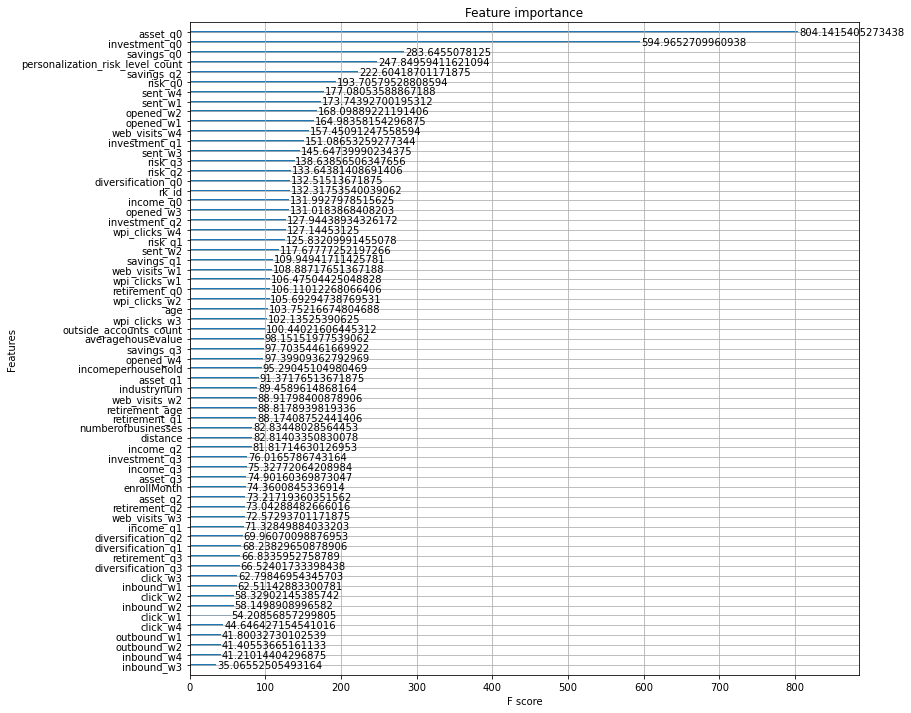

In [53]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(clf,ax=ax,importance_type='gain')

# ROC-AUC

In [54]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return None

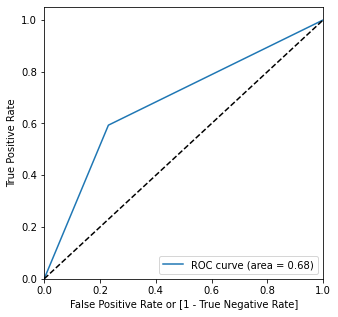

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred, drop_intermediate = False )
draw_roc(y_test,y_pred)

# Grid Search

In [76]:
param_grid = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

clf2 = xgb.XGBClassifier(tree_method='hist', scale_pos_weight=32, random_state=100, enable_categorical=True)

grid_search = GridSearchCV(estimator=clf2, param_grid=param_grid, scoring='roc_auc', cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

# Predict on the test set
y_pred2 = best_model.predict(X_test)

# Evaluate the performance
conf_matrix2 = confusion_matrix(y_test, y_pred2)
accuracy2 = accuracy_score(y_test, y_pred2)
auc2 = roc_auc_score(y_test, y_pred2)

print("Confusion Matrix:")
print(conf_matrix2)
print(f"Accuracy: {accuracy2:.4f}")
print(f"AUC: {auc2:.4f}")
print(classification_report(y_test, y_pred2))

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Confusion Matrix:
[[31898 17838]
 [  578  1513]]
Accuracy: 0.6447
AUC: 0.6825
              precision    recall  f1-score   support

           0       0.98      0.64      0.78     49736
           1       0.08      0.72      0.14      2091

    accuracy                           0.64     51827
   macro avg       0.53      0.68      0.46     51827
weighted avg       0.95      0.64      0.75     51827

